# Analysis of travel behavior

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
from dotenv import load_dotenv
import sql_functions as sf

%matplotlib inline

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

#plot Style
sns.set_style("whitegrid")
sns.set_palette('tab10')

### Import dataframes from postgres

In [2]:
# enter the schema name for your course
schema = 'capstone_travel_index'

df_env = sf.get_dataframe(f'SELECT * FROM {schema}.df_env_scr')
df_gov = sf.get_dataframe(f'SELECT * FROM {schema}.df_gov_scr')
df_soc = sf.get_dataframe(f'SELECT * FROM {schema}.df_soc_scr')
df_lgb = sf.get_dataframe(f'SELECT * FROM {schema}.df_lgb_scr')
df_arr = sf.get_dataframe(f'SELECT iso3, year, africa, americas, east_asia_and_the_pacific, europe, middle_east, other_not_classified, south_asia, total FROM {schema}.arrival_regions')
#df_price = sf.get_dataframe(f'SELECT iso3, item_id, price_avg_eur total FROM {schema}.country_avg_price')
df_regions = sf.get_dataframe(f'SELECT * FROM {schema}.world_regions')

In [3]:
print(df_env.info())
print(df_gov.info())
print(df_soc.info())
print(df_lgb.info())
print(df_regions.info())
print(df_arr.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1930 entries, 0 to 1929
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   iso3       1930 non-null   object        
 1   year       1930 non-null   datetime64[ns]
 2   env_score  1930 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 45.4+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1930 entries, 0 to 1929
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   iso3       1930 non-null   object        
 1   year       1930 non-null   datetime64[ns]
 2   gov_score  1930 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 45.4+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1930 entries, 0 to 1929
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------

In [4]:
print(df_env.head())
print(df_gov.head())
print(df_gov.head())
print(df_lgb.head())
print(df_arr.head())

  iso3       year  env_score
0  AFG 2012-01-01   0.492424
1  AFG 2013-01-01   0.606061
2  AFG 2014-01-01   0.813309
3  AFG 2015-01-01   1.054545
4  AFG 2016-01-01   1.152482
  iso3       year  gov_score
0  AFG 2012-01-01   1.224490
1  AFG 2013-01-01   1.134969
2  AFG 2014-01-01   1.277719
3  AFG 2015-01-01   1.078749
4  AFG 2016-01-01   1.041890
  iso3       year  gov_score
0  AFG 2012-01-01   1.224490
1  AFG 2013-01-01   1.134969
2  AFG 2014-01-01   1.277719
3  AFG 2015-01-01   1.078749
4  AFG 2016-01-01   1.041890
  iso3       year  lgb_score
0  AFG 2012-01-01   2.173913
1  AFG 2013-01-01   2.173913
2  AFG 2014-01-01   2.173913
3  AFG 2015-01-01   2.173913
4  AFG 2016-01-01   2.173913
  iso3       year  africa  americas  east_asia_and_the_pacific  europe  \
0  AFG 2012-01-01     NaN       NaN                        NaN     NaN   
1  AFG 2013-01-01     NaN       NaN                        NaN     NaN   
2  AFG 2014-01-01     NaN       NaN                        NaN     NaN   
3  AFG 2

### Create Datafram with all the scores and travel data

In [5]:
df_analysis = pd.merge(df_env, df_gov, on=['iso3', 'year'])
df_analysis = pd.merge(df_analysis, df_soc, on=['iso3', 'year'])
df_analysis = pd.merge(df_analysis, df_lgb, on=['iso3', 'year'])
df_analysis = pd.merge(df_analysis, df_arr, on=['iso3', 'year'])
df_analysis = pd.merge(df_analysis, df_regions, on=['iso3'])

In [6]:
df_analysis.head()

,iso3,year,env_score,gov_score,soc_score,lgb_score,africa,americas,east_asia_and_the_pacific,europe,middle_east,other_not_classified,south_asia,total,sub-region_name
0,AFG,2012-01-01,0.492424,1.224490,4.038997,2.173913,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,South Asia
1,AFG,2013-01-01,0.606061,1.134969,4.186352,2.173913,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,South Asia
2,AFG,2014-01-01,0.813309,1.277719,4.809461,2.173913,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,South Asia
3,AFG,2015-01-01,1.054545,1.078749,4.152431,2.173913,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,South Asia
4,AFG,2016-01-01,1.152482,1.041890,4.961240,2.173913,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,South Asia


In [7]:
# Select specific years
sel_years = ['2012-01-01', 
             '2013-01-01', 
             '2014-01-01', 
             '2015-01-01', 
             '2016-01-01', 
             '2017-01-01', 
             '2018-01-01', 
             '2019-01-01']

# Filter the DataFrame based on the selected years
df_analysis = df_analysis[df_analysis['year'].isin(sel_years)]

In [8]:

df_analysis['total_score'] = ((df_analysis['env_score'] 
                            + df_analysis['gov_score'] 
                            + df_analysis['soc_score']
                            + df_analysis['lgb_score']) / 4)

## EDA

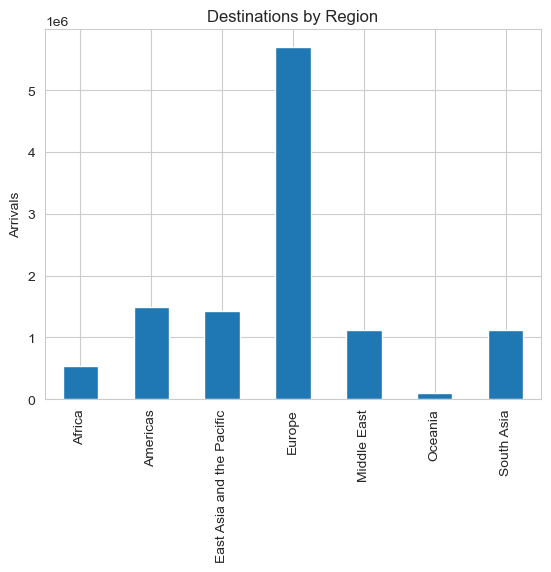

In [9]:
# Group the data by 'sub-region_name' and calculate the sum of 'total'
grouped_data = df_analysis.groupby('sub-region_name')['total'].sum()

# Plot the bar plot
grouped_data.plot.bar()

# Add labels and title to the plot
plt.xlabel('')
plt.ylabel('Arrivals')
plt.title('Destinations by Region')

# Display the plot
plt.show()

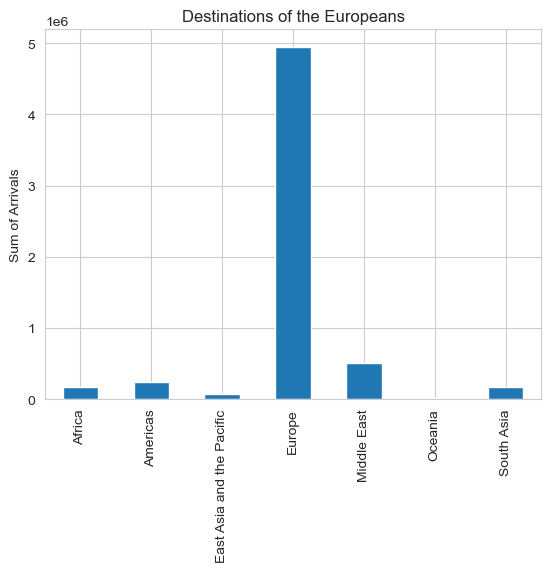

In [10]:
# Group the data by 'sub-region_name' and calculate the sum of the desired columns
grouped_data = df_analysis.groupby('sub-region_name').sum()['europe']

# Plot the bar chart
grouped_data.plot.bar()

# Add labels and a title to the plot
plt.xlabel('')
plt.ylabel('Sum of Arrivals')
plt.title('Destinations of the Europeans')

# Display the plot
plt.show()

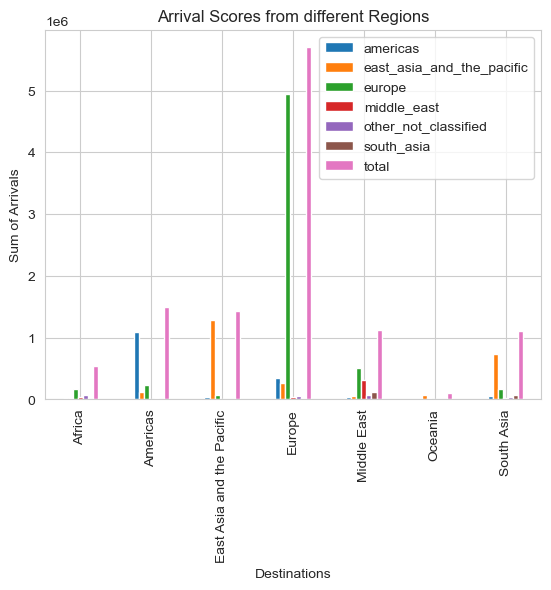

In [11]:
# Group the data by 'sub-region_name' and calculate the sum of the desired columns
grouped_data = df_analysis.groupby('sub-region_name')[['americas', 'east_asia_and_the_pacific', 'europe',
                                              'middle_east', 'other_not_classified', 'south_asia', 'total']].sum()

# Plot the bar chart
grouped_data.plot.bar()

# Add labels and a title to the plot
plt.xlabel('Destinations')
plt.ylabel('Sum of Arrivals')
plt.title('Arrival Scores from different Regions')

# Display the plot
plt.show()

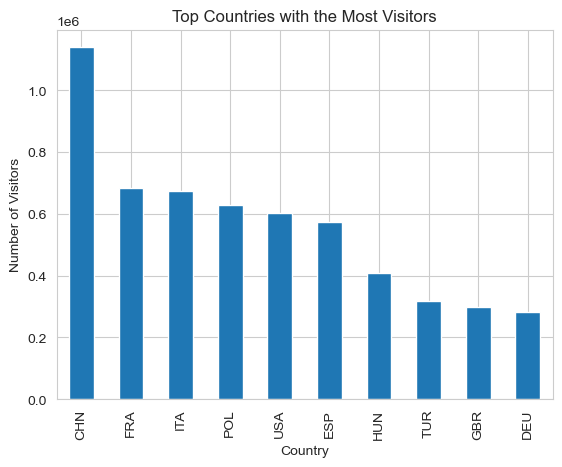

In [12]:
# Sort the DataFrame based on the 'total' column in descending order
sorted_df = df_analysis.groupby('iso3')['total'].sum().sort_values(ascending=False)

# Filter the DataFrame to include only the top countries with the most visitors
top_countries_df = sorted_df.head(10)

# Plot a bar chart of the top countries
top_countries_df.plot(x='iso3', y='total', kind='bar')

# Add labels and a title to the plot
plt.xlabel('Country')
plt.ylabel('Number of Visitors')
plt.title('Top Countries with the Most Visitors')

# Display the plot
plt.show()

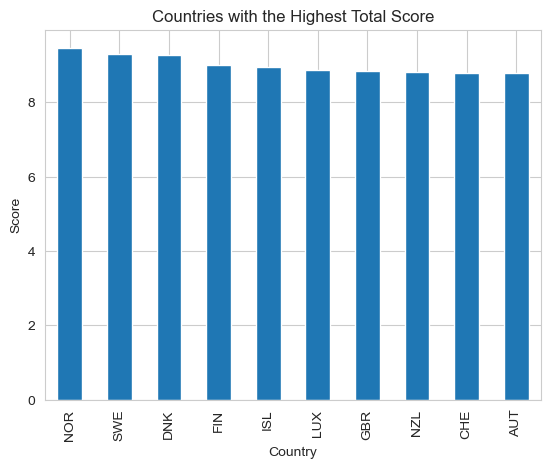

In [13]:
# Sort the DataFrame based on the 'total' column in descending order
sorted_env_df = df_analysis.groupby('iso3')['total_score'].mean().sort_values(ascending=False)

# Filter the DataFrame to include only the top countries with the most visitors
top_env_countries_df = sorted_env_df.head(10)

# Plot a bar chart of the top countries
top_env_countries_df.plot(x='iso3', y='total', kind='bar')

# Add labels and a title to the plot
plt.xlabel('Country')
plt.ylabel('Score')
plt.title('Countries with the Highest Total Score')

# Display the plot
plt.show()

In [14]:
# Create a new column 'rest_of_world' as the sum of scores from regions other than Europe
df_analysis['rest_of_world'] = df_analysis[['africa', 'americas', 'east_asia_and_the_pacific', 'middle_east', 'other_not_classified',
                          'south_asia']].sum(axis=1)

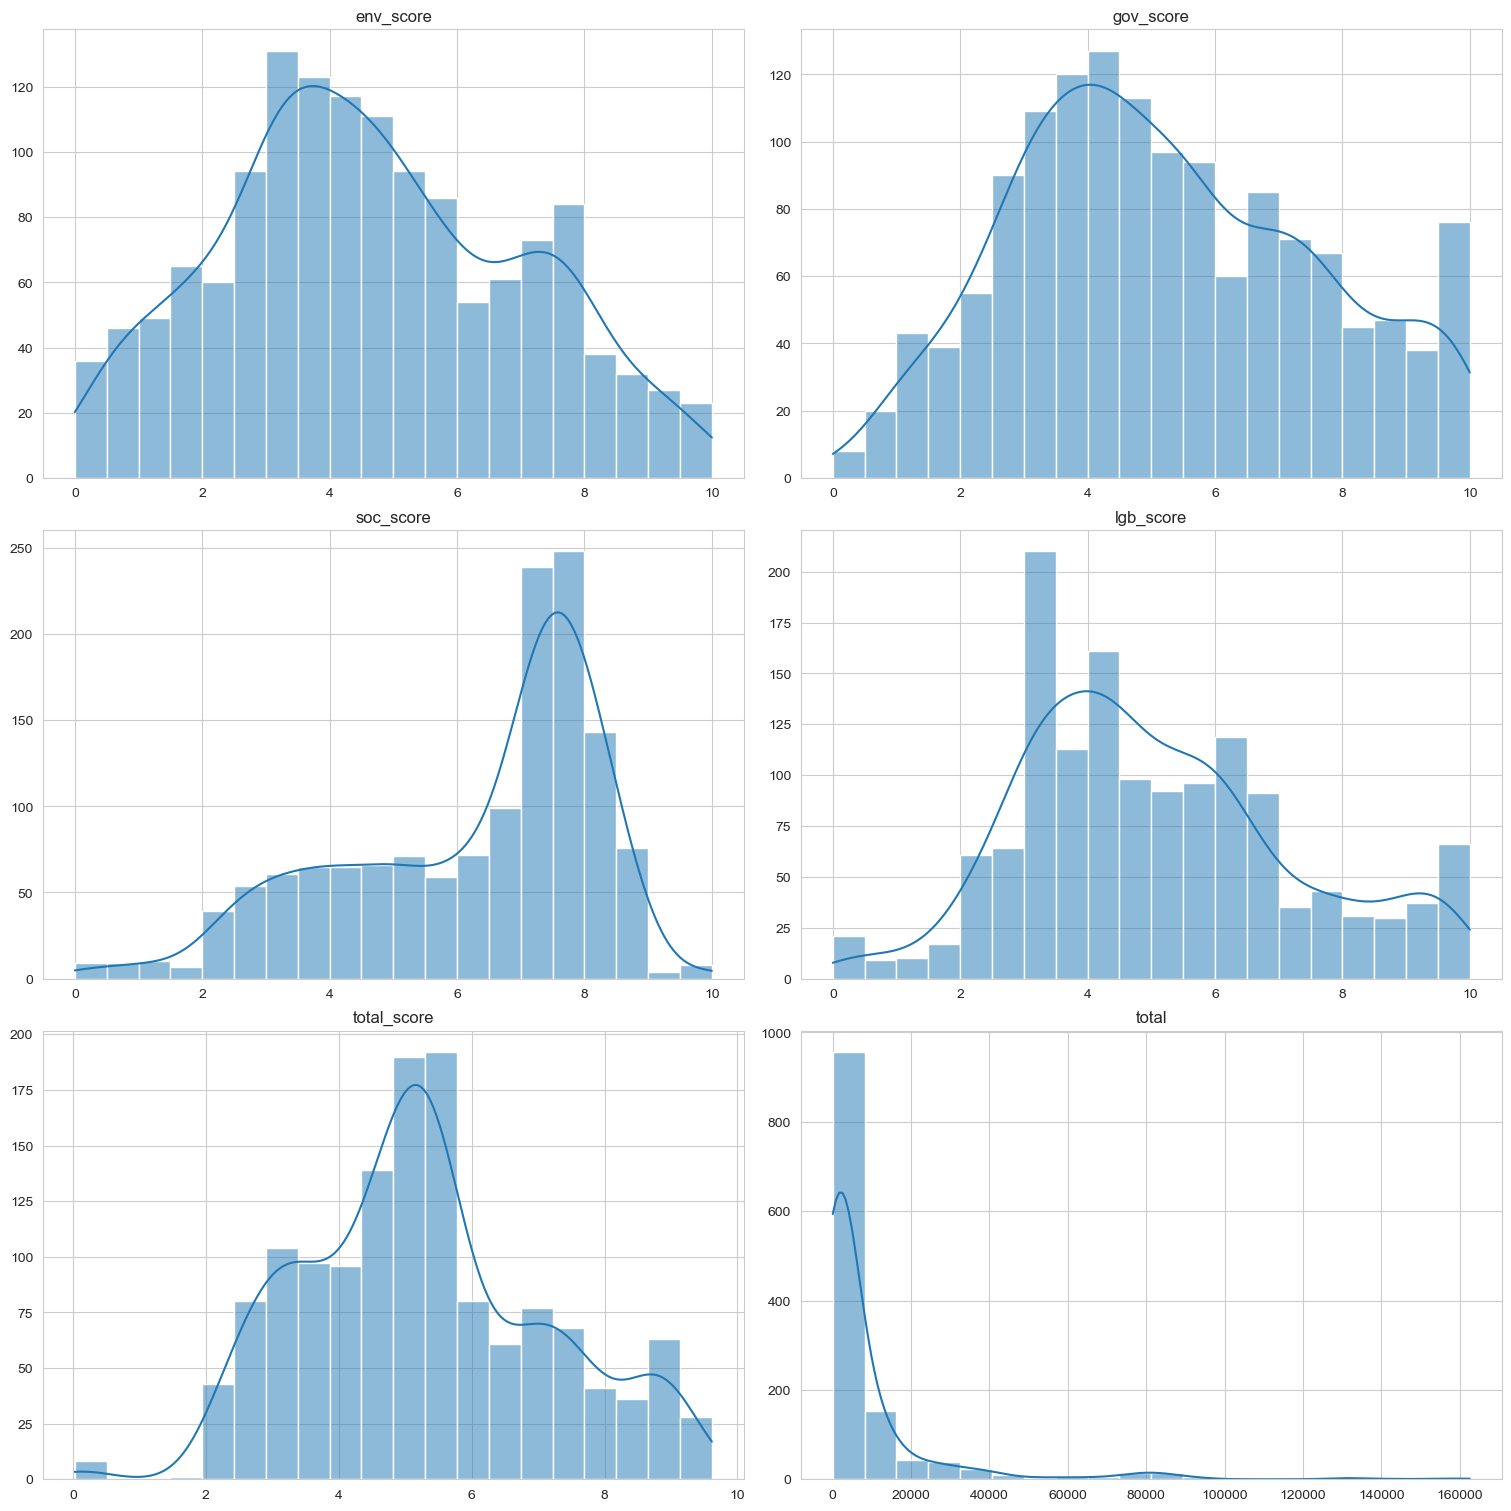

In [15]:
num_col = ['env_score', 'gov_score','soc_score', 'lgb_score', 'total_score', 'total']
rows, cols = 3, 2
plt.figure(figsize=(15,15), constrained_layout = True )

counter = 1
for i in num_col:
    plt.subplot(rows, cols, counter)
    sns.histplot(data = df_analysis, x= i, bins=20, kde=True)
    plt.title(i)
    plt.xlabel("")
    plt.ylabel("")
    counter+=1

In [16]:
# Apply logarithmic transformation to the travel data
df_log = df_analysis.copy()
colum_to_log = ['africa', 'americas', 'east_asia_and_the_pacific', 'europe', 'middle_east', 'other_not_classified', 'south_asia', 'total']
df_log[colum_to_log] = df_log[colum_to_log].apply(lambda x: np.log(x))

/opt/homebrew/Caskroom/miniconda/base/envs/nf_sql/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


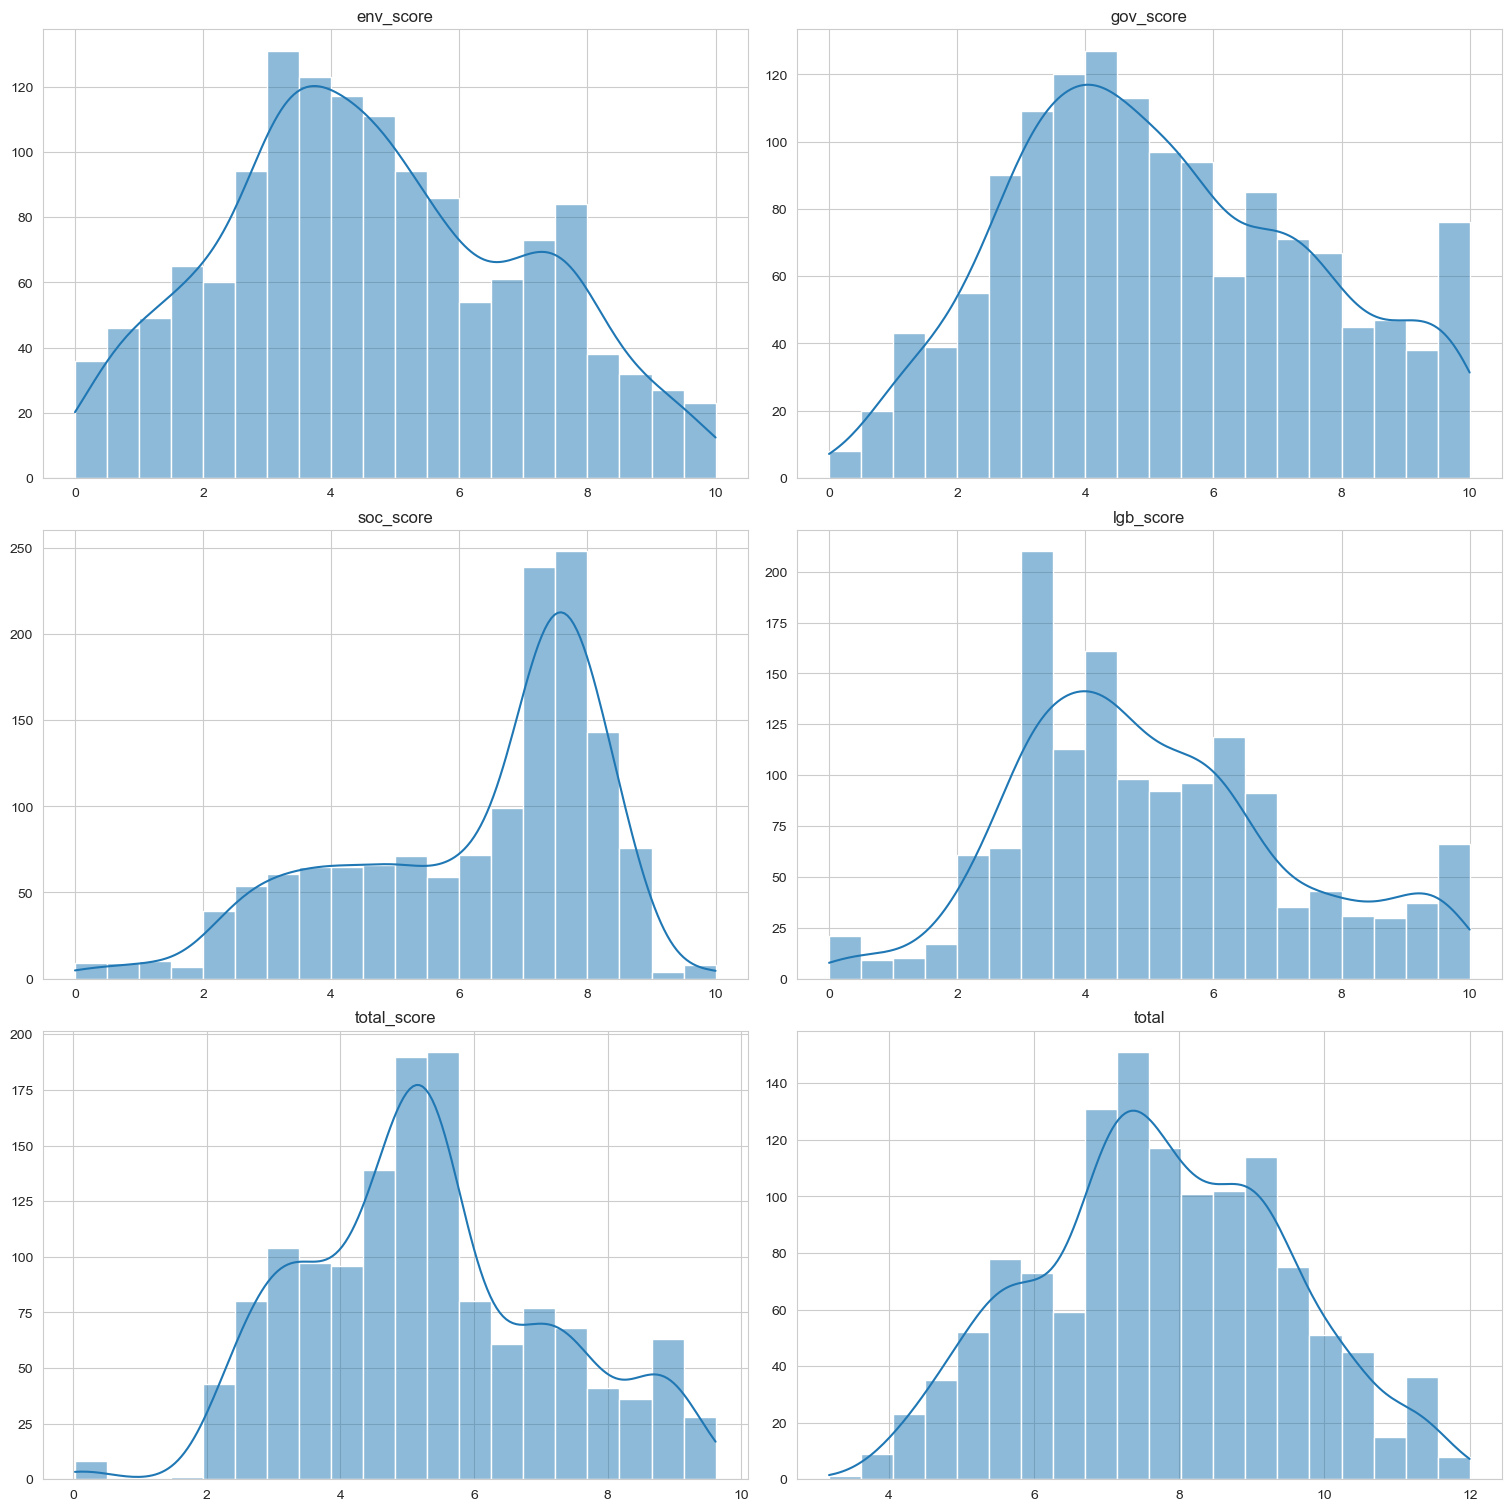

In [17]:
num_col = ['env_score', 'gov_score','soc_score', 'lgb_score', 'total_score', 'total']
rows, cols = 3, 2
plt.figure(figsize=(15,15), constrained_layout = True )

counter = 1
for i in num_col:
    plt.subplot(rows, cols, counter)
    sns.histplot(data = df_log, x= i, bins=20, kde=True)
    plt.title(i)
    plt.xlabel("")
    plt.ylabel("")
    counter+=1

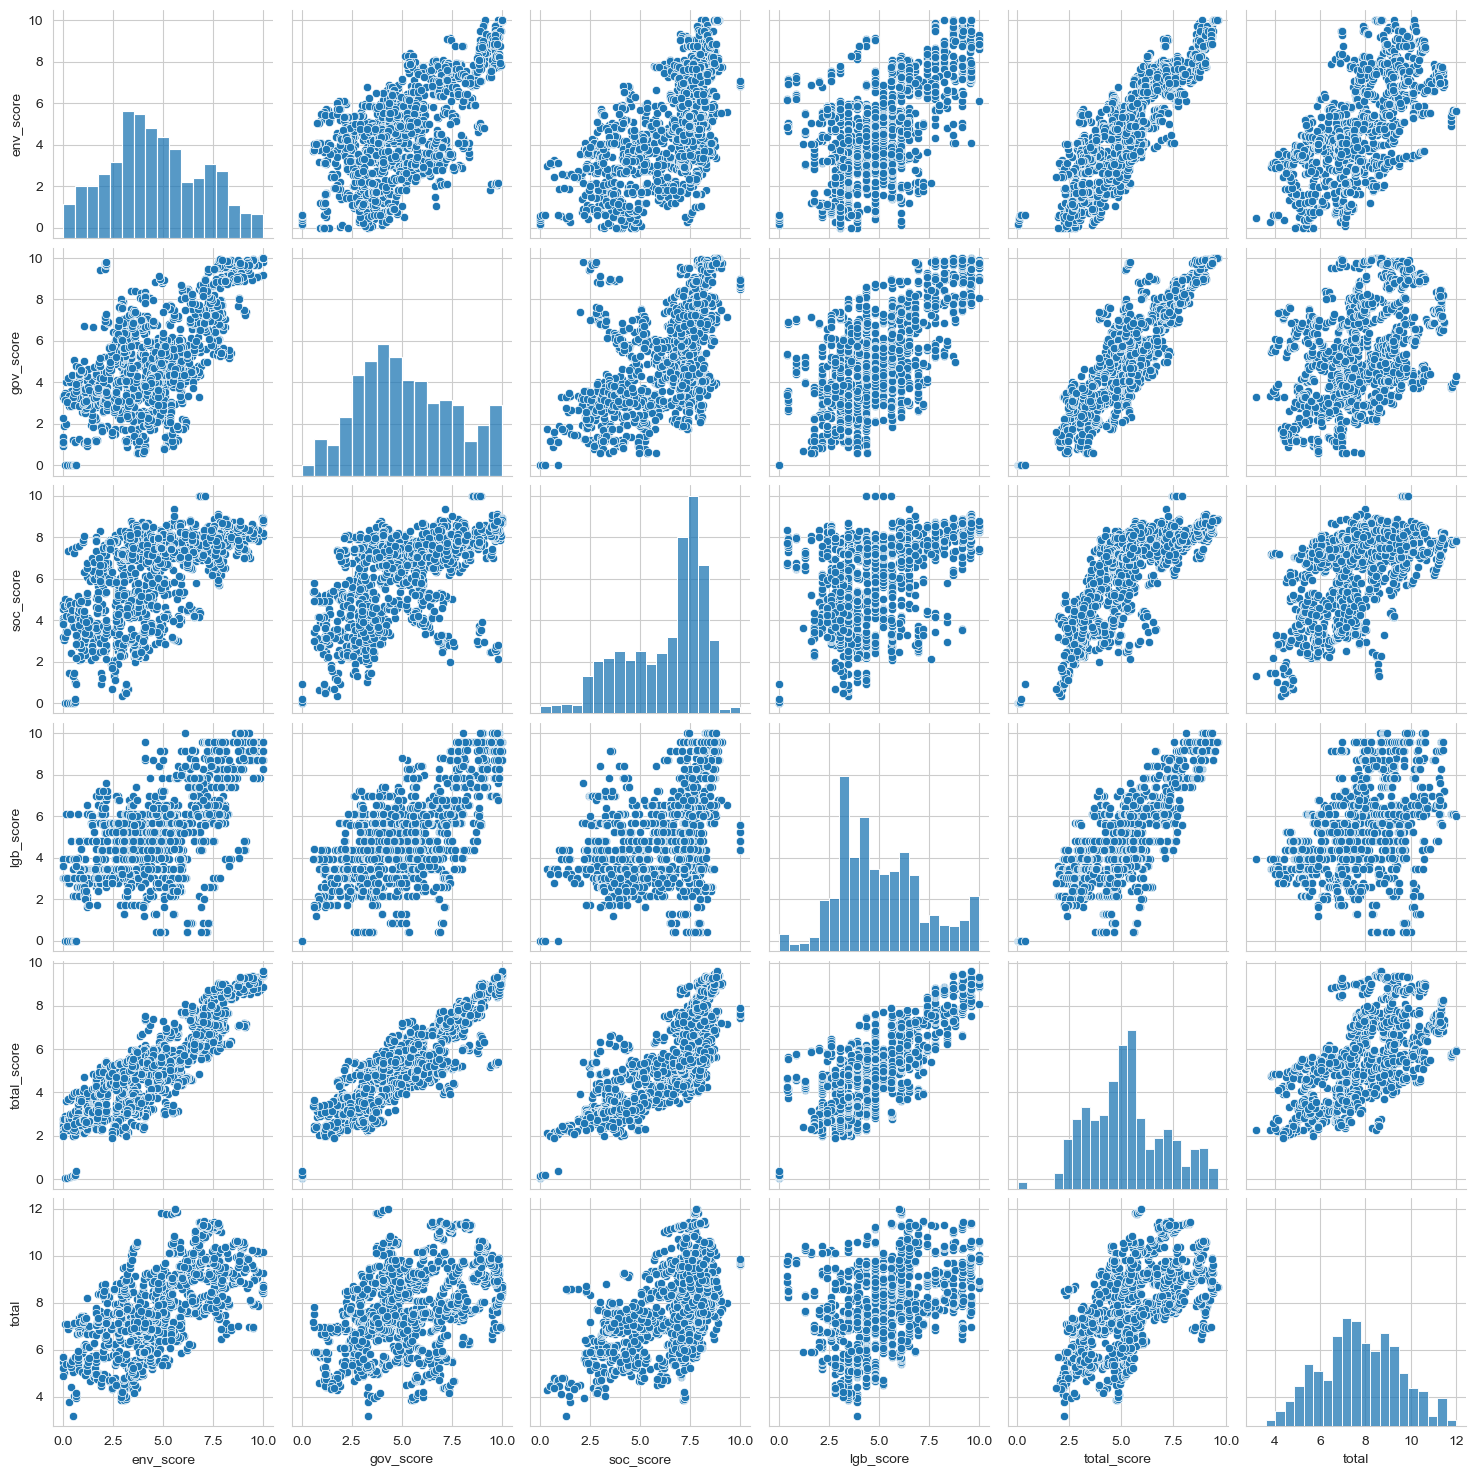

In [18]:
Xpair = df_log[['env_score', 'gov_score', 'soc_score', 'lgb_score', 'total_score', 'total']]
sns.pairplot(Xpair);

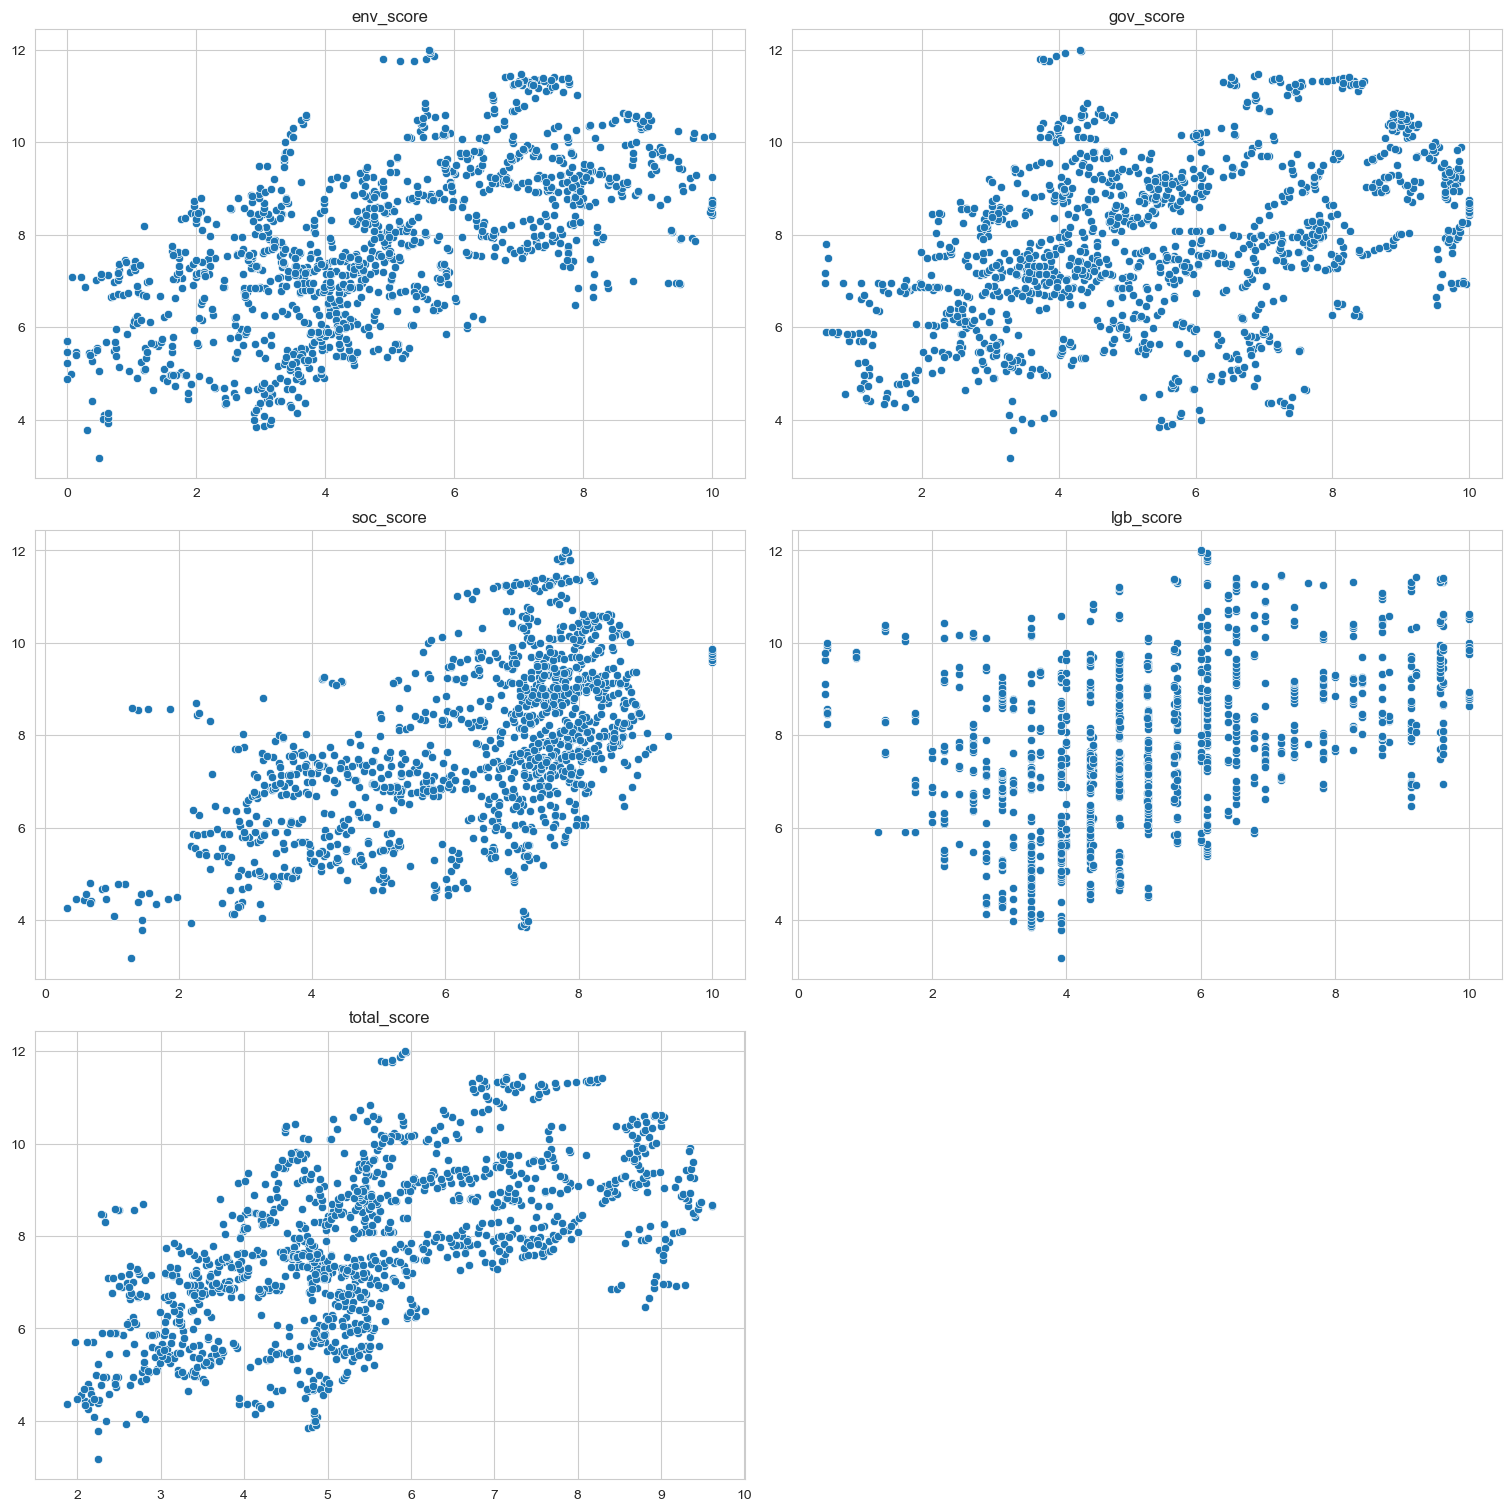

In [19]:
score_col = ['env_score', 'gov_score','soc_score', 'lgb_score', 'total_score']
rows, cols = 3, 2
plt.figure(figsize=(15,15), constrained_layout = True )

counter = 1
for i in score_col:
    plt.subplot(rows, cols, counter)
    sns.scatterplot(data = df_log, x= i,y='total')
    plt.title(i)
    plt.xlabel("")
    plt.ylabel("")
    counter+=1

### Correlation Matrix and Heatmap

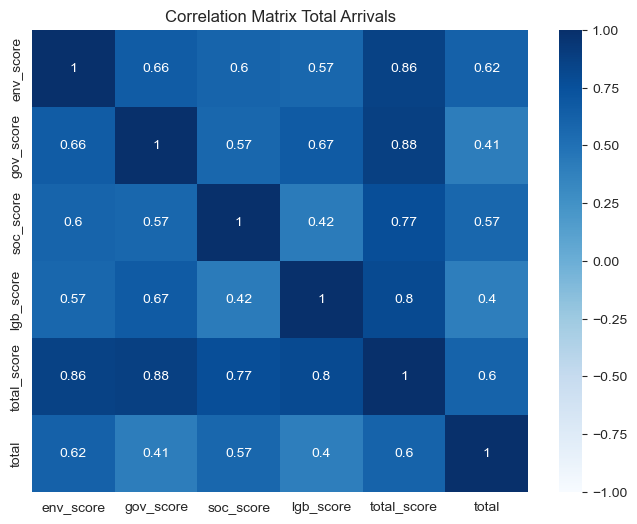

In [20]:
# Compute the correlation matrix
corr_matrix = df_log[['env_score', 'gov_score', 'soc_score', 'lgb_score', 'total_score', 'total']].corr()

# Create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='Blues', vmin=-1, vmax=1)
plt.title('Correlation Matrix Total Arrivals')
plt.show()

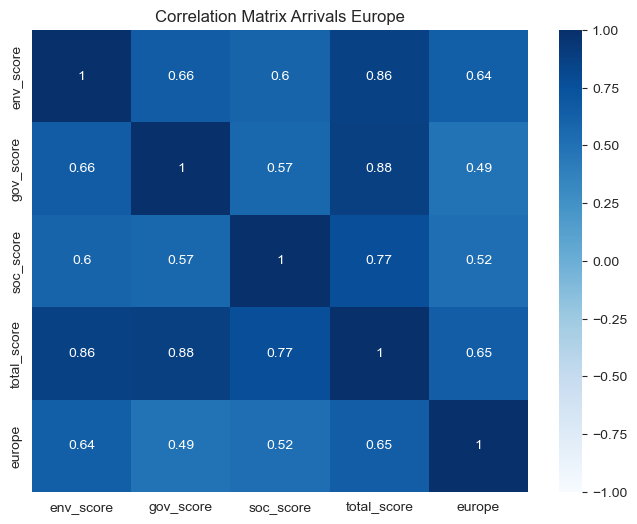

In [21]:
# Compute the correlation matrix
corr_matrix = df_log[['env_score', 'gov_score', 'soc_score', 'total_score', 'europe']].corr()

# Create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='Blues', vmin=-1, vmax=1)
plt.title('Correlation Matrix Arrivals Europe')
plt.show()

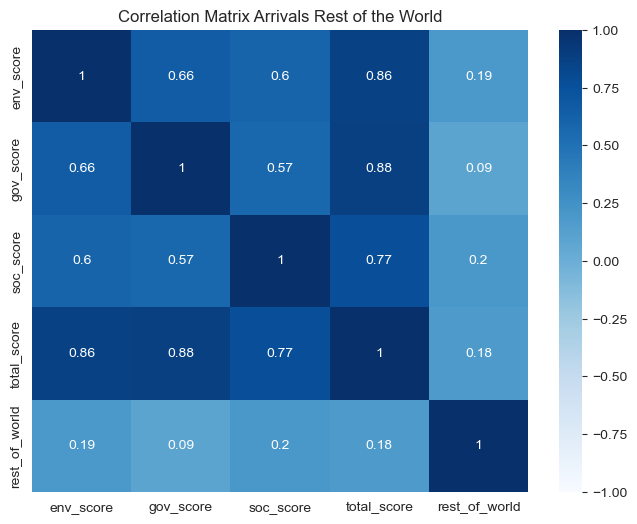

In [22]:
# Compute the correlation matrix
corr_matrix = df_log[['env_score', 'gov_score', 'soc_score', 'total_score', 'rest_of_world']].corr()

# Create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='Blues', vmin=-1, vmax=1)
plt.title('Correlation Matrix Arrivals Rest of the World')
plt.show()

In [23]:
# Filter the DataFrame to include only countries in the 'Europe' sub-region
europe_df = df_log[df_analysis['sub-region_name'] == 'Europe']

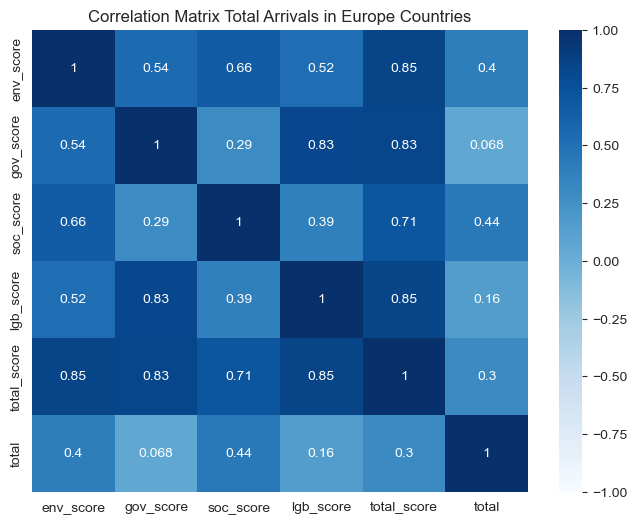

In [24]:
# Compute the correlation matrix
corr_matrix = europe_df[['env_score', 'gov_score', 'soc_score', 'lgb_score', 'total_score', 'total']].corr()

# Create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='Blues', vmin=-1, vmax=1)
plt.title('Correlation Matrix Total Arrivals in Europe Countries')
plt.show()

The correlation coefficient of 0.3 suggests a moderate indicates a positive relationship between tourist numbers and environmental score. It is not extremely strong but still indicates a discernible association.

### Simple linear regression

In [25]:
# Import the statsmodels module
import statsmodels.api as sm

In [26]:
# Prepare data for modeling
df_lin_reg = df_log.dropna()
# Choose the predictor X and add a constant term
X = df_lin_reg[['total_score']]
# Our model needs an intercept so we add a column of 1s:
X = sm.add_constant(X)
# Define dependent variable
y = df_lin_reg['total']

In [27]:
# Create an OLS model
model = sm.OLS(y, X)
# use the data to calculate the intercept and slope
results = model.fit()
# return the output of the model
results.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  total   R-squared:                       0.377
Model:                            OLS   Adj. R-squared:                  0.376
Method:                 Least Squares   F-statistic:                     351.8
Date:                Mon, 03 Jul 2023   Prob (F-statistic):           9.51e-62
Time:                        19:40:36   Log-Likelihood:                -955.99
No. Observations:                 584   AIC:                             1916.
Df Residuals:                     582   BIC:                             1925.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           5.3445      0.164     32.641      0.000       5.023       5.666
total_score     0.5377      0.029     18.756      0.000       0.481       0.594
==============================================================================
Omnibus:                       16.435   Durbin-Watson:                   0.277
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               15.838
Skew:                           0.362   Prob(JB):                     0.000364
Kurtosis:                       2.642   Cond. No.                         18.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

 The provided information is the summary of an Ordinary Least Squares (OLS) regression model. Here's a breakdown of the key statistics and coefficients:

Dep. Variable: total - This indicates that the dependent variable in the regression is 'total'.

R-squared: 0.377 - The R-squared value represents the proportion of the variance in the dependent variable that can be explained by the independent variable(s). In this case, approximately 37.7% of the variance in 'total' can be explained by the independent variable(s).

Adj. R-squared: 0.376 - The adjusted R-squared value is a modified version of the R-squared that takes into account the number of independent variables and sample size. It is slightly lower than the R-squared value in this case.

F-statistic: 351.8 - The F-statistic is a measure of the overall significance of the regression model. A larger F-statistic indicates a more significant relationship between the independent variable(s) and the dependent variable.

Prob (F-statistic): 9.51e-62 - This is the p-value associated with the F-statistic. It represents the probability of obtaining the observed F-statistic by chance. In this case, the p-value is very close to zero, indicating strong evidence against the null hypothesis (no relationship between the variables).

const coefficient: 5.3445 - This represents the estimated intercept or constant term in the regression equation.

total_score coefficient: 0.5377 - This represents the estimated coefficient or slope for the independent variable 'total_score'. It indicates the expected change in the 'total' for a one-unit increase in 'total_score'.

std err: 0.164 - This is the standard error associated with the coefficient estimate.

t-statistic: 32.641 - The t-statistic measures the significance of the coefficient. It is calculated as the coefficient divided by its standard error.

P>|t|: 0.000 - This is the p-value associated with the t-statistic. It represents the probability of obtaining the observed t-statistic by chance. In this case, the p-value is very close to zero, indicating a highly significant relationship between 'total_score' and 'total'.

[0.025 0.975]: 0.023 0.975 - These values represent the 95% confidence interval for the coefficient estimate. It indicates the range of values within which the true population coefficient is likely to fall.

In [28]:
europe_df
# Prepare data for modeling
df_eu_lin_reg = europe_df.dropna()
# Choose the predictor X and add a constant term
Xe = df_eu_lin_reg[['total_score']]
# Our model needs an intercept so we add a column of 1s:
Xe = sm.add_constant(Xe)
# Define dependent variable
y = df_eu_lin_reg['total']

In [29]:
# Create an OLS model
model = sm.OLS(y, Xe)
# use the data to calculate the intercept and slope
results = model.fit()
# return the output of the model
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  total   R-squared:                       0.108
Model:                            OLS   Adj. R-squared:                  0.102
Method:                 Least Squares   F-statistic:                     17.26
Date:                Mon, 03 Jul 2023   Prob (F-statistic):           5.59e-05
Time:                        19:40:36   Log-Likelihood:                -243.05
No. Observations:                 144   AIC:                             490.1
Df Residuals:                     142   BIC:                             496.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           7.0268      0.521     13.481      0.000       5.996       8.057
total_score     0.3028      0.073      4.155      0.000       0.159       0.447
==============================================================================
Omnibus:                       25.747   Durbin-Watson:                   0.323
Prob(Omnibus):                  0.000   Jarque-Bera (JB):                6.454
Skew:                           0.063   Prob(JB):                       0.0397
Kurtosis:                       1.971   Cond. No.                         34.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Change over Years

### Create a DataFrame with the differenz from 2012 to 2019

In [31]:
change_years = ['2012-01-01',
                '2019-01-01']

# Filter the DataFrame based on the selected years
df_analysis_change = df_analysis[df_analysis['year'].isin(change_years)]


In [32]:
#Create a new dataframe with the desired columns:
iso3_codes = df_analysis_change['iso3'].unique()
df_analysis_diff = pd.DataFrame(columns=['iso3', 'env_score_diff', 'gov_score_diff', 'soc_score_diff', 'lgb_score_diff', 'total_score_diff', 'total_diff'])


for iso3 in iso3_codes:
    iso3_rows = df_analysis_change[df_analysis_change['iso3'] == iso3]


    if len(iso3_rows) == 2:
        row_2012 = iso3_rows[iso3_rows['year'] == '2012-01-01']
        row_2019 = iso3_rows[iso3_rows['year'] == '2019-01-01']
        
        env_score_diff = row_2019['env_score'].values[0] - row_2012['env_score'].values[0]
        gov_score_diff = row_2019['gov_score'].values[0] - row_2012['gov_score'].values[0]
        soc_score_diff = row_2019['soc_score'].values[0] - row_2012['soc_score'].values[0]
        lgb_score_diff = row_2019['lgb_score'].values[0] - row_2012['lgb_score'].values[0]
        total_score_diff = row_2019['total_score'].values[0] - row_2012['total_score'].values[0]
        total_diff = row_2019['total'].values[0] - row_2012['total'].values[0]
        
        new_row = {'iso3': iso3, 'env_score_diff': env_score_diff, 'gov_score_diff': gov_score_diff,
                   'soc_score_diff': soc_score_diff, 'lgb_score_diff': lgb_score_diff, 'total_score_diff': total_score_diff, 'total_diff': total_diff}
        
    df_analysis_diff = df_analysis_diff.append(new_row, ignore_index=True)

In [33]:
df_analysis_diff

,iso3,env_score_diff,gov_score_diff,soc_score_diff,lgb_score_diff,total_score_diff,total_diff
0,AFG,0.719697,-0.055659,1.173467,-0.573913,0.315898,NaN
1,AGO,1.226852,0.665121,0.265926,0.452174,0.652518,-310.0
2,ALB,0.279882,0.614100,0.814783,1.217391,0.731539,2892.0
3,AND,0.212542,0.296228,0.119114,1.443478,0.517841,852.0
4,ARE,-0.105219,0.183055,-0.147403,0.730435,0.165217,9050.0
...,...,...,...,...,...,...,...
171,WSM,0.189394,1.168213,0.431163,0.486957,0.568932,46.0
172,YEM,0.934343,-0.991033,0.492358,-0.539130,-0.025866,-508.0
173,ZAF,0.042088,0.423006,1.461251,1.008696,0.733760,1041.0
174,ZMB,-0.736532,-0.608844,0.395575,-1.547826,-0.624407,407.0


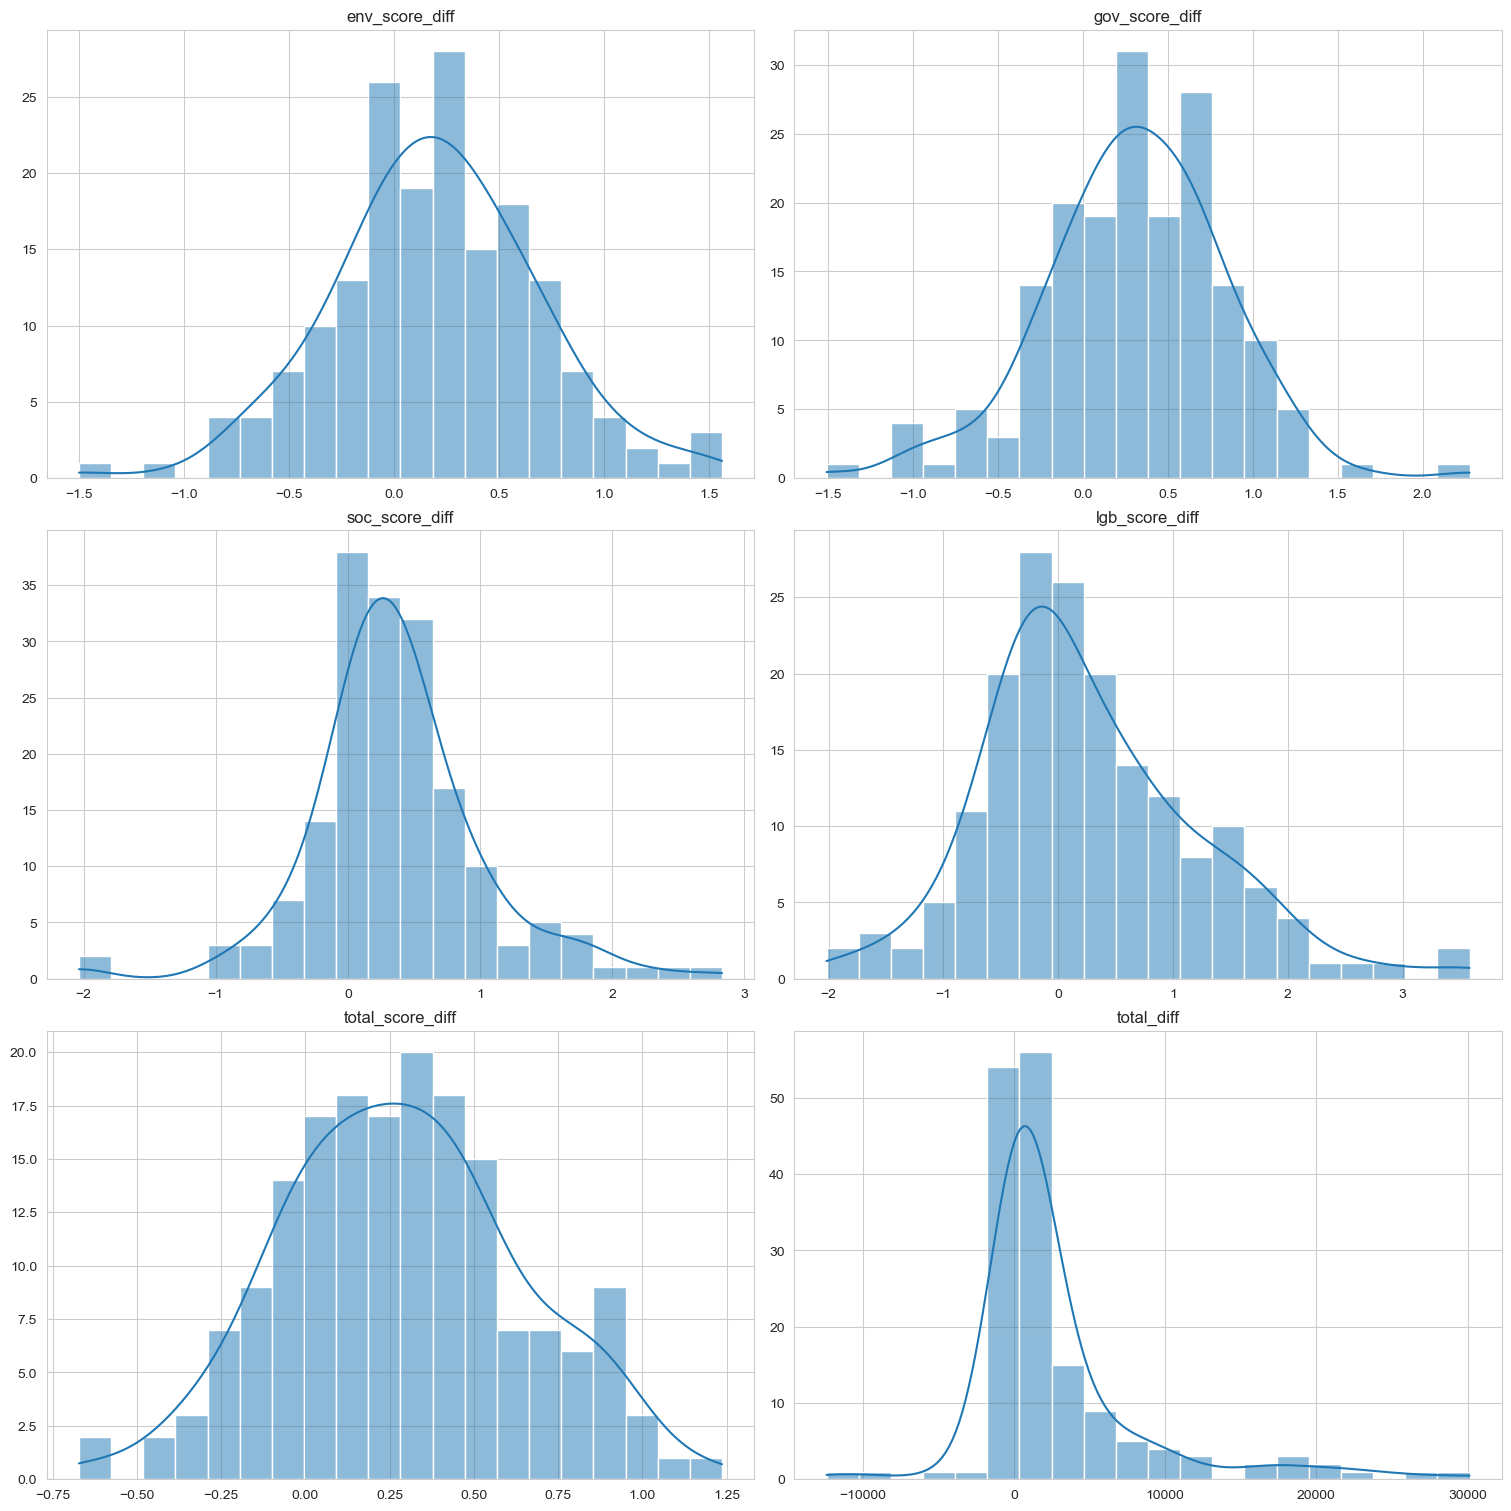

In [38]:
num_col = ['env_score_diff', 'gov_score_diff', 'soc_score_diff', 'lgb_score_diff', 'total_score_diff', 'total_diff']
rows, cols = 3, 2
plt.figure(figsize=(15,15), constrained_layout = True )

counter = 1
for i in num_col:
    plt.subplot(rows, cols, counter)
    sns.histplot(data =df_analysis_diff, x= i, bins=20, kde=True)
    plt.title(i)
    plt.xlabel("")
    plt.ylabel("")
    counter+=1

In [35]:
# Apply logarithmic transformation to the travel data
df_log_diff = df_analysis_diff.copy()
colum_to_log = ['total_diff']
df_log_diff[colum_to_log] = df_log_diff[colum_to_log].apply(lambda x: np.log(x))

/opt/homebrew/Caskroom/miniconda/base/envs/nf_sql/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/homebrew/Caskroom/miniconda/base/envs/nf_sql/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


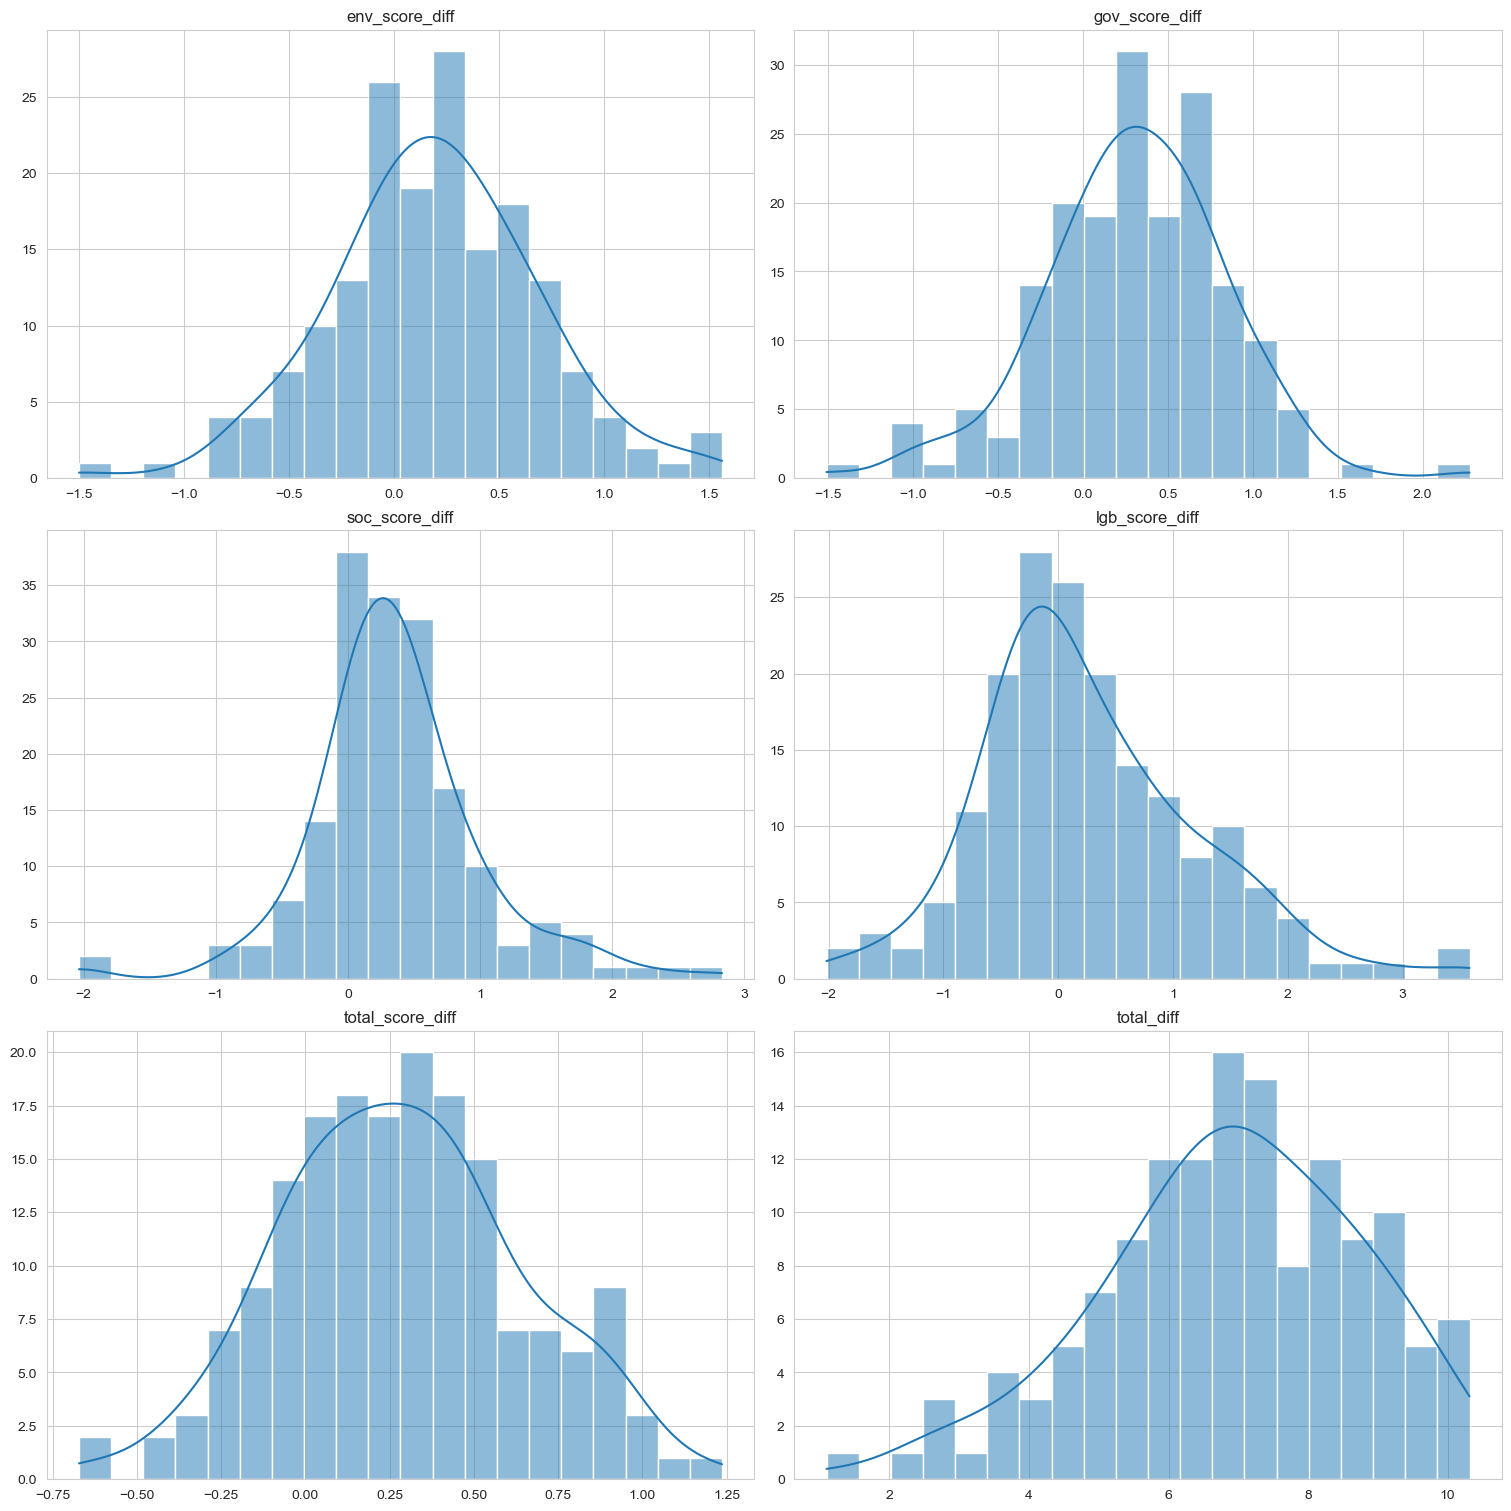

In [37]:
num_col = ['env_score_diff', 'gov_score_diff', 'soc_score_diff', 'lgb_score_diff', 'total_score_diff', 'total_diff']
rows, cols = 3, 2
plt.figure(figsize=(15,15), constrained_layout = True )

counter = 1
for i in num_col:
    plt.subplot(rows, cols, counter)
    sns.histplot(data = df_log_diff, x= i, bins=20, kde=True)
    plt.title(i)
    plt.xlabel("")
    plt.ylabel("")
    counter+=1

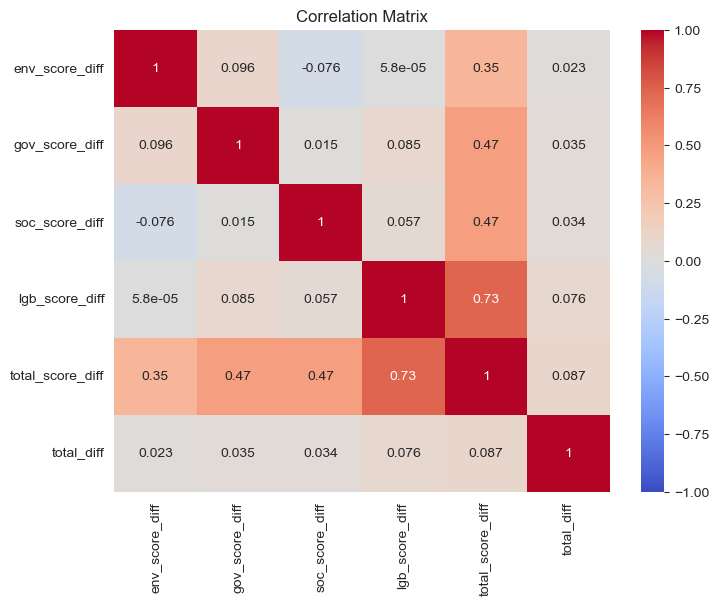

In [39]:
# Compute the correlation matrix
corr_matrix_diff = df_analysis_diff[['env_score_diff', 'gov_score_diff', 'soc_score_diff', 'lgb_score_diff', 'total_score_diff', 'total_diff']].corr()

# Create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix_diff, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()

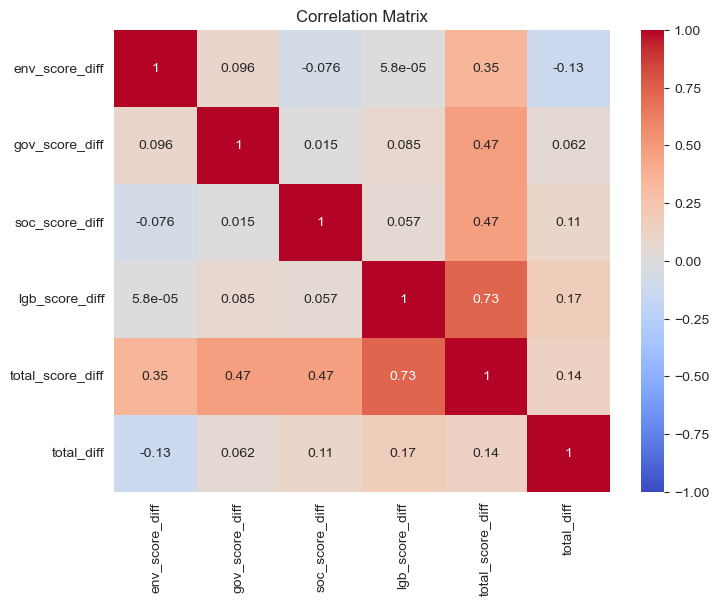

In [41]:
# Compute the correlation matrix
corr_matrix_diff = df_log_diff[['env_score_diff', 'gov_score_diff', 'soc_score_diff', 'lgb_score_diff', 'total_score_diff', 'total_diff']].corr()

# Create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix_diff, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()